In [1]:
from torch.utils.data import DataLoader
import pandas as pd
import torch as th 
import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import PIL
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as T


import src.classification as lc
import src.data_loader as dl

%matplotlib inline  
%load_ext autoreload
%autoreload 2

2023-09-19 21:55:14.459706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
PIL.Image.MAX_IMAGE_PIXELS = 108000001


In [3]:
def plot_confusion(y_t, y_p, labels):
    cm = confusion_matrix(y_t, y_p)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    
    
@th.no_grad()
def predict(model, data_loader):
    y_t, y_p = [], []
    
    for bs in tqdm.tqdm(data_loader):
        x = bs['img'].cuda()
        y_t.append(bs['label'].argmax(dim=1).detach().cpu().numpy())
        y_p.append(model(x).argmax(dim=1).detach().cpu().numpy())
        
    return np.concatenate(y_t), np.concatenate(y_p)

In [4]:
# model_checkpoint = '/home/cemmi/Documents/aicrowd-mos/Mosquito-Classifiction/lightning_logs/version_3/checkpoints/epoch=4-val_loss=0.2824241518974304-val_accuracy=0.9133956432342529-val_multiclass_accuracy=0.7767815589904785.ckpt'
# model_checkpoint = '/home/cemmi/Documents/aicrowd-mos/Mosquito-Classifiction/lightning_logs/version_18/checkpoints/epoch=1-val_loss=0.25722965598106384-val_accuracy=0.9121495485305786-val_multiclass_accuracy=0.8630045652389526.ckpt'

version = '51'
model_name = 'epoch=5-val_loss=0.15289585292339325-val_f1_score=0.8219492435455322-val_multiclass_accuracy=0.7882785201072693'
model_checkpoint = f'./lightning_logs/version_{version}/checkpoints/{model_name}.ckpt'

img_dir = "../data_round_2/final"
annotations_csv = "../data_round_2/phase2_train_v0.csv"

class_dict = {
    "albopictus": th.tensor([1, 0, 0, 0, 0, 0], dtype=th.float),
    "culex": th.tensor([0, 1, 0, 0, 0, 0], dtype=th.float),
    "japonicus/koreicus": th.tensor([0, 0, 1, 0, 0, 0], dtype=th.float),
    "culiseta": th.tensor([0, 0, 0, 1, 0, 0], dtype=th.float),
    "anopheles": th.tensor([0, 0, 0, 0, 1, 0], dtype=th.float),
    "aegypti": th.tensor([0, 0, 0, 0, 0, 1], dtype=th.float),
}

labels = list(class_dict.keys())
transform = dl.pre_process("")
bs = 256

In [1]:
model = lc.MosquitoClassifier.load_from_checkpoint(model_checkpoint).eval().cuda()

NameError: name 'lc' is not defined

In [6]:
annotations_df = pd.read_csv(annotations_csv)
train_df, val_df = train_test_split(
    annotations_df,
    test_size=0.2,
    stratify=annotations_df["class_label"],
    random_state=200,
)

val_df = val_df[val_df['img_fName'].str.contains(r"train_\d+.jpeg")]

#annotations_df = pd.read_csv(annotations_csv)
#train_df = annotations_df.sample(frac=0.8, random_state=200)
#val_df = annotations_df.drop(train_df.index)

train_dataset = dl.SimpleClassificationDataset(
    train_df,
    img_dir,
    class_dict,
    transform,
    dl.aug("resize"),
    class_balance=False,
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=6,
)

val_dataset = dl.SimpleClassificationDataset(
    val_df,
    img_dir,
    class_dict,
    transform,
    dl.aug("resize"),
    class_balance=False,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=6,
)


In [7]:
val_df

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
2506,train_02506.jpeg,3024,4032,1460,2179,1777,2436,albopictus
603,train_00603.jpeg,3016,4032,1169,2344,1799,2934,culex
5337,train_05337.jpeg,1024,1365,298,652,561,920,culex
8316,train_08316.jpeg,2160,3840,837,1957,1253,2460,albopictus
1249,train_01249.jpeg,1024,1365,702,797,804,907,culex
...,...,...,...,...,...,...,...,...
1140,train_01140.jpeg,3264,2448,887,1459,1435,1807,albopictus
7807,train_07807.jpeg,768,1024,263,472,432,609,culex
5745,train_05745.jpeg,1200,1600,478,504,708,771,culex
8386,train_08386.jpeg,1816,4032,185,1473,838,2144,culiseta


In [8]:
v_t, v_p = predict(model, val_dataloader)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.51s/it]


0.8219492609123185

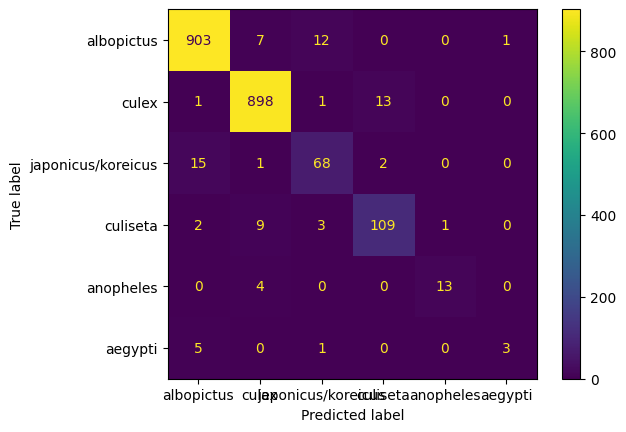

In [9]:
plot_confusion(v_t, v_p, labels)
f1_score(v_t, v_p, average='macro')

In [10]:
# 0.61 f1 val version_3 epoch=4
# 0.66 f1 val version_18 epoch=1
# 0.54 f1 val version_1 epoch=1
# 0.56 f1 val version_11 epoch=1
# 0.56 f1 val version_16 epoch=3
# 0.66 f1 val version_19 epoch=1
# 0.64 f1 val version_26 epoch=1
# 0.76 f1 val version_26 epoch=3
# 0.77 f1 val version_26 epoch=4
# 0.66 f1 val version_28 epoch=4
# 0.62 f1 val version_28 epoch=2
# 0.57 f1 val version_27 epoch=4
# 0.53 f1 val version_27 epoch=2
# 0.68 f1 val version_29 epoch=2
# 0.73 f1 val version_29 epoch=3
# 0.69 f1 val version_30 epoch=2
# 0.75 f1 val version_30 epoch=4
# 0.71 f1 val version_35 epoch=2
# 0.74 f1 val version_35 epoch=4
# 0.80 f1 val version_39 epoch=4

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [01:44<00:00,  3.16s/it]


0.982074275852233

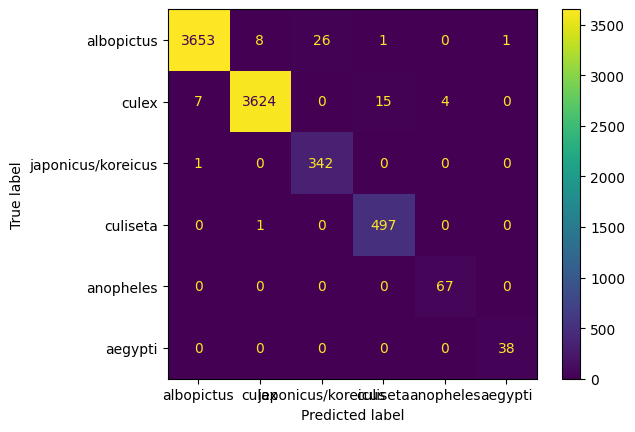

In [11]:
t_t, t_p = predict(model, train_dataloader)
plot_confusion(t_t, t_p, labels)

f1_score(t_t, t_p, average='macro')

In [12]:
f1_score(t_t, t_p, average='macro')

0.982074275852233

# Failed Cases

In [13]:
genus = ["anopheles", "culex", "culiseta"]
species = ["aegypti", "albopictus", "japonicus/koreicus"]

In [14]:
df = val_df.copy()
df['label'] = v_t
df['pred'] = v_p
df['correct_match'] = v_t == v_p
df['label_type'] = df['class_label'].isin(genus).map({True: 'genus', False: 'species'})
df['predicted_type'] = df['pred'].isin([1, 3, 4]).map({True: 'genus', False: 'species'})
cls_missed = df[df.correct_match == False]


len(cls_missed), len(cls_missed[cls_missed.label_type == cls_missed.predicted_type])

(78, 61)

Text(0.5, 1.0, 'Miss Classification of CLIP-ViT-L-14')

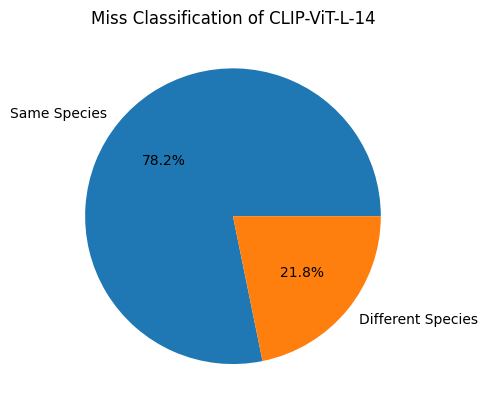

In [15]:
labels = 'Same Species', 'Different Species'
sizes = [
    len(cls_missed[cls_missed.label_type == cls_missed.predicted_type]),
    len(cls_missed[cls_missed.label_type != cls_missed.predicted_type])
]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Miss Classification of CLIP-ViT-L-14')

In [16]:
cls_missed

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label,label,pred,correct_match,label_type,predicted_type
3903,train_03903.jpeg,1247,1291,241,219,816,925,japonicus/koreicus,2,0,False,species,species
3255,train_03255.jpeg,1908,4032,0,570,1908,3727,culiseta,3,2,False,genus,species
9194,train_09194.jpeg,1932,1953,391,235,1703,1669,albopictus,0,2,False,species,species
10337,train_10337.jpeg,3024,4032,1843,1427,2729,2386,culiseta,3,1,False,genus,genus
9023,train_09023.jpeg,2268,4032,945,1790,1287,2087,japonicus/koreicus,2,0,False,species,species
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9270,train_09270.jpeg,4032,3024,1033,129,3132,1934,culex,1,3,False,genus,genus
988,train_00988.jpeg,3024,4032,1285,2167,1774,2569,culex,1,3,False,genus,genus
449,train_00449.jpeg,1600,1200,614,524,987,874,japonicus/koreicus,2,1,False,species,genus
7465,train_07465.jpeg,3024,4032,132,680,2733,3767,albopictus,0,2,False,species,species


In [17]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [32]:
failed_cases = DataLoader(
    dl.SimpleClassificationDataset(
        val_df[
        (df.class_label == 'aegypti') 
        & (df.label != df.pred)
        ],
        img_dir,
        class_dict,
        T.ToTensor(),
        dl.aug("resize"),
        class_balance=False,
    ),
    batch_size=256,
    shuffle=False,
    num_workers=6,
)
grid = make_grid(next(iter(failed_cases))['img'], nrow=16)

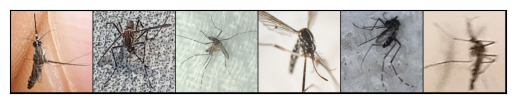

In [33]:
show(grid)

In [34]:
from torchvision.utils import save_image

save_image(grid, 'clip_vit_l_14_missclassified_different_species.png')

# TNSE Visualization

In [20]:
@th.no_grad()
def extract_embeddings(model, data_loader):
    embs, y_t = [], []

    emb_head = th.nn.Sequential(*(list(model.cls.label.label.children())[:-1])).eval()
    backbone = model.cls.backbone.eval()
    
    for bs in tqdm.tqdm(data_loader):
        x = bs['img'].cuda()

        emb = backbone(x)
        emb = emb_head(emb)
        y_t.append(bs['label'].argmax(dim=1).detach().cpu().numpy())
        embs.append(emb.detach().cpu().numpy())
        
    return np.concatenate(embs), np.concatenate(y_t)

In [21]:
emb, t = extract_embeddings(model, val_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:36<00:00,  4.09s/it]


In [22]:
el, c = np.unique(t, return_counts=True)

In [23]:
el, c

(array([0, 1, 2, 3, 4, 5]), array([923, 913,  86, 124,  17,   9]))

In [24]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=200, n_jobs=-1)
tsne_emb = tsne.fit_transform(emb)

Text(0.5, 1.0, 'TNSE ViT-L-14 Embeddings')

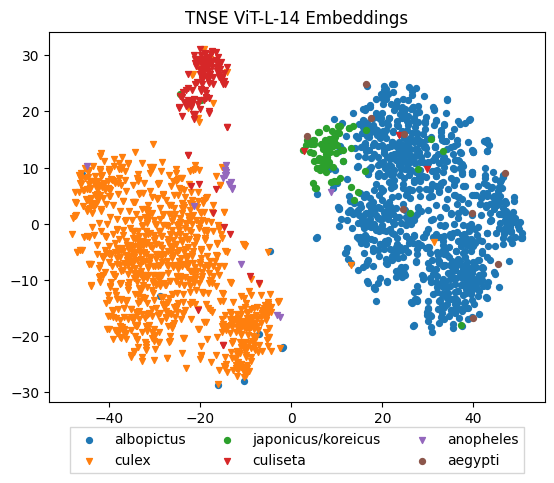

In [25]:
names = list(class_dict.keys())

for e in  el:
    idx = np.where(t == e)[0]
    
    plt.scatter(tsne_emb[idx, 0], 
                tsne_emb[idx, 1], 
                label=names[int(e)],
                marker='v' if names[int(e)] in genus else 'o',
                s=18
                )
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, ncol=3)
plt.title('TNSE ViT-L-14 Embeddings')

# Compare CPU vs GPU resul

In [34]:
model_cpu = lc.MosquitoClassifier.load_from_checkpoint(model_checkpoint).eval().cpu()
model_gpu = lc.MosquitoClassifier.load_from_checkpoint(model_checkpoint).eval().cuda()

In [35]:
model_checkpoint

'./lightning_logs/version_29/checkpoints/epoch=2-val_loss=0.29584163427352905-val_accuracy=0.9183968901634216-val_multiclass_accuracy=0.8534045815467834.ckpt'

In [36]:
val_dataloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
)


with th.no_grad():
    print('From Real Images')
    for i, bs in enumerate(val_dataloader):
        if i > 10:
            break
        img = bs['img']
        r_c = model_cpu(img)
        r_g = model_gpu(img.to('cuda'))
    
        print("CPU", r_c[0])
        print("GPU", r_g[0])
        print('=========')



From Real Images
CPU tensor([ 4.6555, -2.8319,  0.8391, -3.6518, -0.8794,  1.2030])
GPU tensor([ 4.6555, -2.8319,  0.8391, -3.6518, -0.8795,  1.2030], device='cuda:0')
CPU tensor([ 4.7234, -1.9283,  0.6089, -3.7057, -1.9895,  0.2144])
GPU tensor([ 4.7234, -1.9283,  0.6089, -3.7057, -1.9895,  0.2144], device='cuda:0')
CPU tensor([ 2.7304, -0.8722,  0.7962, -3.3529, -0.9907,  0.9629])
GPU tensor([ 2.7304, -0.8722,  0.7962, -3.3529, -0.9907,  0.9629], device='cuda:0')
CPU tensor([-2.3435,  4.1989, -1.9405,  1.7908,  0.8980, -1.6143])
GPU tensor([-2.3435,  4.1989, -1.9405,  1.7908,  0.8980, -1.6143], device='cuda:0')
CPU tensor([-3.2505, -1.5928, -1.1634,  5.0503, -1.1633, -0.5984])
GPU tensor([-3.2505, -1.5928, -1.1634,  5.0503, -1.1633, -0.5984], device='cuda:0')
CPU tensor([-2.1057,  2.1543, -1.4572,  0.4159, -1.1079, -2.1182])
GPU tensor([-2.1057,  2.1543, -1.4572,  0.4159, -1.1079, -2.1181], device='cuda:0')
CPU tensor([-3.1463,  4.9215, -2.8017,  1.6815, -0.4281, -2.0215])
GPU tensor

# YOLO Submission

In [21]:
# Submit


test_annotation = './yolo/submissions_yolo_m.csv'
test_dir = '/home/cemmi/Documents/aicrowd-mos/data/test'

test_df = pd.read_csv(test_annotation)
test_dataset = dl.SimpleClassificationDataset(
    test_df,
    test_dir,
    class_dict,
    transform,
    dl.aug("resize"),
    class_balance=False,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=6,
)
_, test_p = predict(model, test_dataloader)

p_labels = [labels[c] for c in test_p]

test_df['class_label'] = p_labels

100%|███████████████████████████████████████████████████████████████| 11/11 [00:45<00:00,  4.18s/it]


In [22]:
test_df.to_csv('submissions_yolo_m_clip_v_26_vit_l_epoch=4.csv', index=False)

# Ensemble

In [59]:
n = 10
W = [i/n for i in range(0, n+1)]
f1_vals = []

version1 = '19'
model_name1 = 'epoch=1-val_loss=0.2737879455089569-val_accuracy=0.9109034538269043-val_multiclass_accuracy=0.822079598903656'
model_checkpoint1 = f'./lightning_logs/version_{version}/checkpoints/{model_name}.ckpt'

version2 = '18'
model_name2 = 'epoch=1-val_loss=0.25722965598106384-val_accuracy=0.9121495485305786-val_multiclass_accuracy=0.8630045652389526'
model_checkpoint2 = f'./lightning_logs/version_{version}/checkpoints/{model_name}.ckpt'

backbone = lc.MosquitoClassifier.load_from_checkpoint(model_checkpoint1).cpu()
model2 = lc.MosquitoClassifier.load_from_checkpoint(model_checkpoint2).cpu()

with th.no_grad():
    for w in W:
        model = lc.MosquitoClassifier(head_version=2)
        model.load_state_dict(model2.state_dict())

        for o, b in zip(model.parameters(), backbone.parameters()):
            o.data = w*o + (1 - w)*b
        
        model.eval()
        model.cuda()
        v_t, v_p = predict(model, val_dataloader)
        
        print(v_p)
        f1_val = f1_score(v_t, v_p, average='macro')
        print(f'Weight {w} - val score {f1_val}')
        f1_vals.append(f1_val)


100%|██████████████████████████████████████| 7/7 [00:34<00:00,  4.97s/it]


Weight 0.0 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:34<00:00,  4.95s/it]


Weight 0.1 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:35<00:00,  5.02s/it]


Weight 0.2 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:34<00:00,  4.90s/it]


Weight 0.3 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:34<00:00,  4.90s/it]


Weight 0.4 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:35<00:00,  5.07s/it]


Weight 0.5 - val score 0.6647083746693502


100%|██████████████████████████████████████| 7/7 [00:35<00:00,  5.10s/it]


Weight 0.6 - val score 0.6647083746693502


 43%|████████████████▎                     | 3/7 [00:28<00:38,  9.66s/it]


KeyboardInterrupt: 